<div align="right">March 2021</div>

<a href="https://colab.research.google.com/github/dewdotninja/robotics/blob/master/ME208583/hws/merobo21_hw2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 01208583 Homework # 2

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    


In [ ]:
!pip install slycot

In [ ]:
!pip install control

Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

In [7]:
# compute bounds
S_bnd = 20*np.log10(0.02)
print("Low frequency bound on S = " + str(S_bnd) + " dB")
print("Low frequency bound on L = " + str(-S_bnd) + " dB")
T_bnd = 20*np.log10(0.05)
print("High frequency bound on T and L = "+str(T_bnd)+" dB")

Low frequency bound on S = -33.979400086720375 dB
Low frequency bound on L = 33.979400086720375 dB
High frequency bound on T and L = -26.020599913279625 dB


<b> Problem: </b> let us design a controller for our same old robot joint driven by DC motor 
    developed since the first module
\begin{equation} 
P(s) = \frac{1}{5s^2 + 0.02s}
\end{equation}
<div align="right">(1)</div>

with the following design specs
<ol>
<li> steady state error is eliminated </li>
<li> low frequency disturbance is attenuated at least 0.02 below 3 rad/s </li>
<li> high frequency measurement noise is attenuated 0.05 above 200 rad/s </li>
<li> closed-loop stable, with phase margin at least 40 degrees </li>
</ol>

<p />From the above discussion, this can be translated to stability and performance bounds

<ol>
<li> $L(s)$ has an integrator. Note that $P(s)$ already has one</li>
<li> $|S(j\omega)| \leq -34 dB \rightarrow |L(j\omega)| \geq 34 dB$ below 3 rad/s</li>
<li> $|T(j\omega)| \leq -26 dB \rightarrow |L(j\omega)| \leq -26 dB$ above 200 rad/s</li>
<li> $L(j\omega)$ has at least 40 degrees phase margin, or $max|S(j\omega)|\leq 3.3 dB$<b>*</b></li>
</ol>


<p />To aid this design problem, we write a function lshape() in the cell below. 


In [11]:
def lshape(C,P, lf, lfb, hf, hfb, pm ):
    assert lf > 0   # avoid bad values
    assert lfb > 0
    assert hf > lf
    assert hfb < 0
    assert 0 < pm < 90
    L = C*P # form loop transfer function
    # create a suitable range of frequency from lf, hf
    lf_log10 = np.log10(lf)
    w_start = np.floor(lf_log10)-1
    hf_log10 = np.log10(hf)
    w_end = np.ceil(hf_log10)+1
    w = np.logspace(w_start,w_end, 1000)
    
    # frequency response of L
    Lmag, Lph, om = ctl.freqresp(L, w)
    Lmag_db = np.squeeze(20*np.log10(Lmag))
    Lph_deg = np.squeeze(np.degrees(Lph))
    
    # create bound vectors
    lf_mask = np.where(om<lf, lfb, 0)
    hf_mask = np.where(om<hf, 0, hfb)
    lf_bnd = lf_mask*np.ones(om.shape)
    hf_bnd = hf_mask*np.ones(om.shape)
    
    # check whether violation occurs
    lf_idxv = np.where(om>lf)
    lf_idx = lf_idxv[0][0]   # find index of low-freq region
    hf_idxv = np.where(om<hf)
    hf_idx = hf_idxv[0][-1]  # find index of high-freq region
    lfmag = Lmag_db[:lf_idx]
    hfmag = Lmag_db[hf_idx:]
    if min(lfmag)<lfb:
        lf_legend = "LF bound (violated)"
    else:
        lf_legend = "LF bound"
    if max(hfmag)>hfb:
        hf_legend = "HF bound (violated)"
    else:
        hf_legend = "HF bound"    
    
    # desired phase margin vectors
    pmvec = (pm-180)*np.ones(om.shape)
    
    # compute gain/phase margins
    g_margin, ph_margin, wgm, wpm = ctl.margin(L)
    ph_at_crossover = (ph_margin-180)
    # Loopshaping plot
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    fig.suptitle('$L(j\omega)$ v.s. bounds')
    ax1.semilogx(om, Lmag_db,'k-', om, lf_bnd, 'm-.', om, hf_bnd,'b-.')
    ax1.legend(["$|L(j\omega)|$",lf_legend,hf_legend],loc="lower left")
    ax1.grid(True)
    ax1.set_ylabel('magnitude (dB)')
    
    ax2.semilogx(om, Lph_deg,'k-',om, pmvec,'b-', wpm, ph_at_crossover,'r*')
    if ph_margin > pm:
        pmtext = "phase margin = " + str(round(ph_margin)) + " degrees"
    else:
        pmtext = "phase margin = " + str(round(ph_margin)) + " degrees (violated)"
        
    ax2.text(wpm,ph_at_crossover,pmtext)
    
    dpmtext = "Desired PM (" + str(pm) + " degrees)"
    ax2.set_xlabel('frequency (rad/s)')
    ax2.set_ylabel('phase (deg)')
    ax2.legend(["$\measuredangle L(j\omega)$",dpmtext],loc="lower left")
    ax2.grid(True)    
    
    # plot magnitude of S and T v.s bounds
    S = 1/(1+L)
    T = L/(1+L)
    
    # frequency responses of S and T
    Smag, Sph, om = ctl.freqresp(S, w)
    Tmag, Tph, om = ctl.freqresp(T, w)
    
    Smag_db = np.squeeze(20*np.log10(Smag))
    Tmag_db = np.squeeze(20*np.log10(Tmag))
   
    # check whether violation occurs
    lf_idxv = np.where(om>lf)
    lf_idx = lf_idxv[0][0]   # find index of low-freq region
    hf_idxv = np.where(om<hf)
    hf_idx = hf_idxv[0][-1]  # find index of high-freq region
    lfSmag = Smag_db[:lf_idx]
    hfTmag = Tmag_db[hf_idx:]
    if max(lfSmag)>-lfb:
        lf_legend = "LF bound (violated)"
    else:
        lf_legend = "LF bound"
    if max(hfTmag)>hfb:
        hf_legend = "HF bound (violated)"
    else:
        hf_legend = "HF bound"    
        
    # create data vector for stability bound in mid freq region
    
    om_mid = om[lf_idx:hf_idx]
    pm_r = np.radians(pm)
    x = np.sin(0.5*(np.pi - pm_r))/(np.sin(pm_r)) 
    x = 20*np.log10(x)
    bnds_mid = x*np.ones(om_mid.shape)
    
    ST_peak = max(max(Smag_db),max(Tmag_db))
    if ST_peak > x:
        mf_legend = "Stability bound (violated)"
    else:
        mf_legend = "Stability bound"
    
    plt.figure(figsize=(8,4))
    plt.semilogx(om,Smag_db,'k-',om,Tmag_db,'g-',om,-lf_bnd,'m-.',om,hf_bnd,'b-.',om_mid,bnds_mid,'r-.')
    plt.xlabel('frequency (rad/s)')
    plt.ylabel('magnitude (dB)')
    plt.legend(["$|S(j\omega)|$","$|T(j\omega)|$",lf_legend,hf_legend, mf_legend])
    plt.grid(True)
    plt.title('$|S(j\omega)|$ and $|T(j\omega)|$ v.s. bounds')
    plt.show()


where the arguments are as follows:
<ul>
<li /><b>C : </b>Controller
<li /><b>P : </b>Plant
<li /><b>lf : </b>Define low frequency region from 0 - lf (rad/s)
<li /><b>lfb : </b>Low frequency bound for $L(s)$
<li /><b>hf : </b>Define high frequency region from hf - $\infty$ (rad/s)
<li /><b>hfb : </b>High frequency bound for $L(s)$
<li /><b>pm : </b>Phase margin (degrees)
</ul>
    

In [8]:
# create the plant
s = ctl.tf('s')
P = 1/(5*s**2 + 0.02*s)

In [9]:
lf = 3 # low frequency here
lfb = 34 # your answer 
hf = 200 # high frequency here
hfb = -26 # your answer
pm = 40


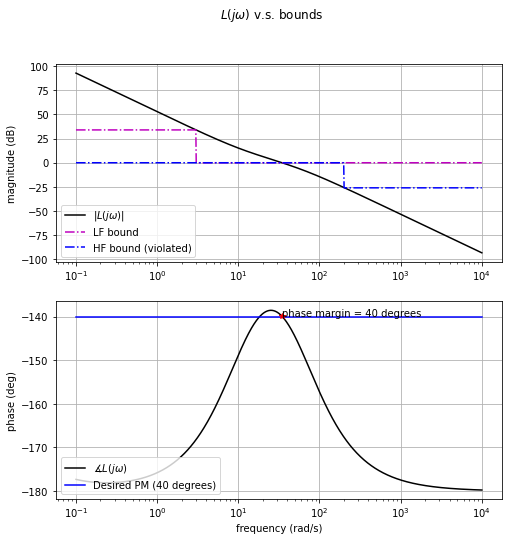

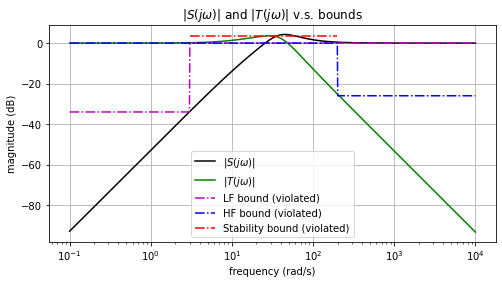

In [66]:
# Note : this controller yields Bode plot of L(s) that is very close to the specs.
# There is still some small violation at the high frequency boundary.
# I am satisfied with this design. If you can do better than this, great!

C = 10800*(s+11.4)/(s+56) # your controller
lshape(C,P, lf, lfb, hf, hfb,pm )

Iterate the above cell until you achieve a controller that meets the specs.

Then plot the closed-loop step response (adjust tvec if necessary)

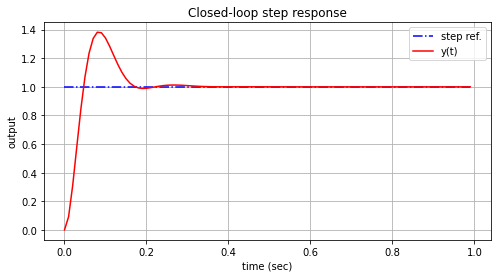

In [67]:
L = C*P
T = L/(1+L)
tvec = np.arange(0,1.0,0.01)
r = np.ones(tvec.shape)
tout, y = ctl.step_response(T,tvec)
plt.figure(figsize=(8,4))
plt.plot(tout,r,'b-.',tout,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(['step ref.','y(t)'])
plt.title('Closed-loop step response')
plt.show()

To make sure that this design meets all the specification, the disturbance and noise responses in the time-domain need to be 
evaluated. Create a function to plot output response of arbitrary function.


In [70]:
def plot_response(sys,u,t,title):
    tout, y = ctl.forced_response(sys,t, u)
    truncated_idx = 150  # get rid of transient
    tout = tout[truncated_idx:]
    u = u[truncated_idx:]
    y = y[truncated_idx:]
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    fig.suptitle(title)
    ax1.plot(tout,u,'b-')
    ax1.grid(True)
    ax1.set_ylabel('input')
    
    ax2.plot(tout,y,'r-')
    ax2.grid(True)
    ax2.set_ylabel('output')
    ax2.set_xlabel('time (sec)')

    plt.show()    

From the design specifications, the required disturbance attenuation is at least 0.02 for frequency below 3 rad/s.
Since the attenuatiton is the least at $\omega = 3$ rad/s, we use this frequency as our test point.

Recall that the closed-loop transfer function for the output disturbance response is $S(s)$.
The plot from this cell must confirm that the controller meets this attenuation performance.

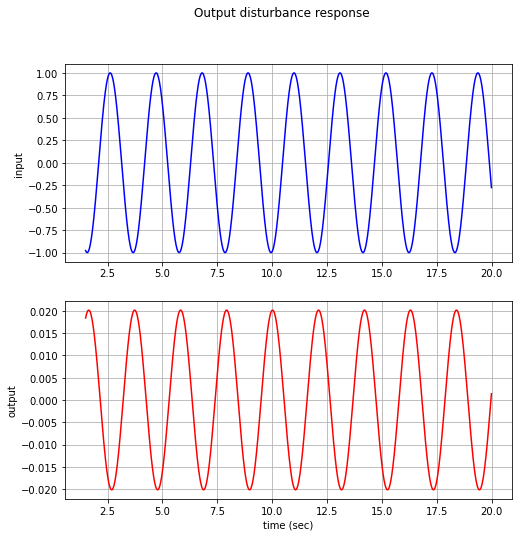

In [71]:
L = C*P
S = 1/(1+L)
t = np.arange(0,20,0.01)  # adjust if needed
w = 3  # rad/s
u = np.sin(w*t)
plot_response(S,u, t, 'Output disturbance response')

Note : The output magnitude must swing within 0.02

Use the same plot function on the complementary sensitivity $T(s)$ to verify that, with a noise input $u(t)=\sin(\omega t)$ 
where $\omega = 200$ rad/s, the output should swing within $\pm 0.05$ unit.

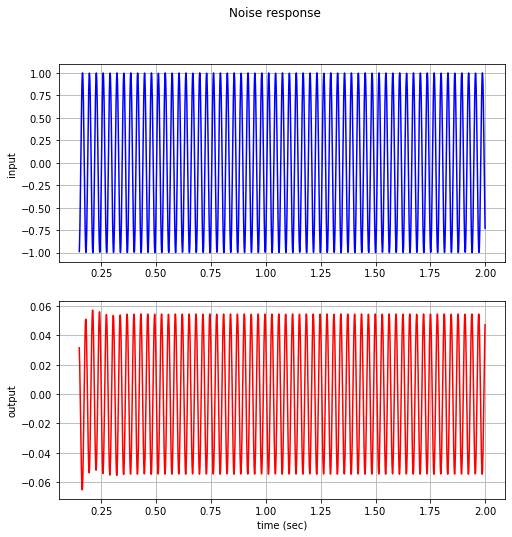

In [72]:
t = np.arange(0,2,0.001) # adjust if needed
w = 200  # rad/s
u = np.sin(w*t)
T = L/(1+L)
plot_response(T,u, t, 'Noise response')

<b>Note : </b> The output swing is a little larger than $\pm 0.05$, conforming to the fact that the high frequency bound is silightly
    violated at the corner.

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>